# Necessary Weather Data

In this Jupyter notebook we note the necessary variables needed for PV production calculations. Moreover, we are going to list a series of possible weather databases.

## Weather databases

1. Meteonorm 8.1
2. PVGIS TMY
3. SOLCast TMY
4. Solar Anywhere TGY
5. Solargis TMY
6. NASA-SSE

## Weather variables to take into account

1. Global Horizontal Irradiance (GHI - kWh/m^2/month)
2. Horizontal Diffuse Radiation (DHI - kWh/m^2/month)
3. Temperature (celcius)
4. Wind velocity (m/s)
5. Linke turbidity (-)
6. Relative Humidity (%)

###### Side note on Linke Turbidity (TL)

Linke turbidity (TL) is really a lumped “haziness” index that accounts for all the extra extinction of sunlight beyond what a perfectly clean, dry atmosphere would do. That “extra extinction” comes mainly from two things:

Aerosols (pollution, dust, smoke, volcanic particles, etc.)
This is the “pollution” part. Urban smog or Saharan dust events push TL upward.

Water vapor absorption
Humid tropical air or summer days with high precipitable water also increase TL.

TL isn’t only a pollution indicator. A very humid but clean region (say, the Amazon) will also have a high TL even if the air is not polluted.

In [1]:
# Fetch hourly PVGIS SARAH-3 with pvlib (multi-year)
# pip install pvlib pandas pyarrow  (pyarrow optional for Parquet)

from __future__ import annotations
import datetime
import requests
import pandas as pd
import pvlib

LAT, LON = 41.9028, 12.4964
START_YEAR = 2011       
N_YEARS    = 12
ALTITUDE_METERS = 0
RADDATABASE = "PVGIS-SARAH3"
API_BASE = "https://re.jrc.ec.europa.eu/api/v5_3/"
OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"


def fetch_year(year: int) -> pd.DataFrame:
    """Return hourly PVGIS data (UTC index) with pvlib-mapped column names."""
    start, end = f"{year}-01-01", f"{year}-12-31"
    df, meta = pvlib.iotools.get_pvgis_hourly(
        LAT, LON,
        start=start, end=end,
        raddatabase=RADDATABASE,
        components=True,               # get GHI/DHI/DNI etc.
        usehorizon=True,
        map_variables=True,
        url=API_BASE,
        outputformat="json",
    )
    return df.sort_index(), meta

def fetch_dewpoint(year):
    start, end = f"{year}-01-01", f"{year}-12-31"
    params = {
        'latitude': LAT,
        'longitude': LON,
        'start_date': start,
        'end_date': end,
        'hourly': 'dew_point_2m,relative_humidity_2m,temperature_2m',
        'timezone': 'auto'
    }
    
    response = requests.get(OPEN_METEO_URL, params=params)
    if response.status_code != 200:
        raise Exception(f"API request failed: {response.status_code}")
    
    data = response.json()
    
    # Create DataFrame with dew point
    meteo_df = pd.DataFrame({
        'timestamp': pd.to_datetime(data['hourly']['time']),
        'dew_point_2m': data['hourly']['dew_point_2m']
    })
    meteo_df = meteo_df.set_index('timestamp')
    return meteo_df['dew_point_2m'].values


all_years = []
for i in range(N_YEARS):
    y = START_YEAR + i
    print(f"Fetching {y} ({RADDATABASE}) …")

    dfx, meta = fetch_year(y)
    ALTITUDE_METERS = meta['inputs']['location']['elevation']
    # dfx['TL'] = pvlib.clearsky.lookup_linke_turbidity(dfx.index, LAT, LON).values
    dfx.index = dfx.index - pd.Timedelta(minutes=10)
    if dfx.index.tz is None or dfx.index.tz == datetime.timezone.utc:
        dfx.index = dfx.index.tz_convert("Europe/Rome")
    dfx['dew_point_2m'] = fetch_dewpoint(y)
    all_years.append(dfx)

Fetching 2011 (PVGIS-SARAH3) …
Fetching 2012 (PVGIS-SARAH3) …
Fetching 2013 (PVGIS-SARAH3) …
Fetching 2014 (PVGIS-SARAH3) …
Fetching 2015 (PVGIS-SARAH3) …
Fetching 2016 (PVGIS-SARAH3) …
Fetching 2017 (PVGIS-SARAH3) …
Fetching 2018 (PVGIS-SARAH3) …
Fetching 2019 (PVGIS-SARAH3) …
Fetching 2020 (PVGIS-SARAH3) …
Fetching 2021 (PVGIS-SARAH3) …
Fetching 2022 (PVGIS-SARAH3) …


In [2]:
weather = pd.concat(all_years).sort_index()
weather.head()

,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,dew_point_2m
time,,,,,,,,
2011-01-01 01:00:00+01:00,0.0,0.0,0.0,0.0,5.88,1.52,0,3.7
2011-01-01 02:00:00+01:00,0.0,0.0,0.0,0.0,5.55,1.66,0,3.8
2011-01-01 03:00:00+01:00,0.0,0.0,0.0,0.0,5.36,1.66,0,3.8
2011-01-01 04:00:00+01:00,0.0,0.0,0.0,0.0,4.88,1.79,0,3.6
2011-01-01 05:00:00+01:00,0.0,0.0,0.0,0.0,4.64,1.72,0,3.5


#### Weather Data Preprocessing

pvgis returns poa_direct, poa_sky_diffuse, poa_ground_diffuse. To mimick pvsyst as much as possible, we are going to transform them into GHI, DHI, DNI. This is done via pvlib.

In [3]:
import pvlib

loc = pvlib.location.Location(LAT, LON, tz="Europe/Rome", altitude=ALTITUDE_METERS)
solpos = loc.get_solarposition(weather.index)
aoi = pvlib.irradiance.aoi(0, 0, solpos['apparent_zenith'], solpos['azimuth'])
poa_total = weather['poa_direct'] + weather['poa_sky_diffuse'] + weather['poa_ground_diffuse']
mask = (poa_total > 20)

weather[['ghi','dni','dhi']] = 0.0
am_rel  = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(ALTITUDE_METERS)
am_abs = pvlib.atmosphere.get_absolute_airmass(am_rel, pressure)

weather['airmass'] = am_abs
weather['relative_humidity'] = pvlib.atmosphere.rh_from_tdew(weather['temp_air'], weather['dew_point_2m'])
weather['precipitable_water'] = pvlib.atmosphere.gueymard94_pw(
    weather['temp_air'], weather['relative_humidity']
)

result = pvlib.irradiance.gti_dirint(
    poa_global=(weather.loc[mask, 'poa_direct'] + weather.loc[mask, 'poa_sky_diffuse'] + weather.loc[mask, 'poa_ground_diffuse']),
    aoi=aoi.loc[mask],
    solar_zenith=solpos.loc[mask, 'apparent_zenith'],
    solar_azimuth=solpos.loc[mask, 'azimuth'],
    times=weather.index[mask],
    surface_tilt=0,
    surface_azimuth=0,
)

weather.update(result)

c:\dev\data-analisys\notes-on-pvlib\venv\lib\site-packages\pvlib\irradiance.py:2515: RuntimeWarning: 681 points failed to converge after 30 iterations. best_diff:
time
2011-01-12 08:00:00+01:00       2.365347
2011-01-13 08:00:00+01:00       2.321227
2011-01-14 08:00:00+01:00       2.256008
2011-01-16 08:00:00+01:00       2.123163
2011-01-17 08:00:00+01:00    9999.000000
                                ...     
2022-10-17 08:00:00+02:00    9999.000000
2022-10-18 08:00:00+02:00    9999.000000
2022-10-20 08:00:00+02:00    9999.000000
2022-10-24 08:00:00+02:00    9999.000000
2022-12-12 08:00:00+01:00       1.172537
Length: 681, dtype: float64
  warnings.warn(


# PV plant anagraphics definition

We are now going to take into account the specifics of the PV plant. In particular, the mounting configuration, the PV tracking configuration, the cell temperature model according to pvsyst's practices.

In [4]:
TRACKING_TYPE = "fixed"  # "fixed" | "single_axis" | "two_axis"
RACKING_MODEL = "open_rack"  # "open_rack" or "close_mount" (used for temp/IAM conventions)
FIXED_TILT = 0
FIXED_AZIMUTH = 0
AXIS_TILT = 0.0
AXIS_AZIMUTH = 180.0       # N-S axis: 0 or 180 (pvlib uses degrees from North, CW)
MAX_ANGLE = 60.0
BACKTRACK = False
GCR = 0.35
K = 0.05
U_C, U_V = (29.0, 0.0) if RACKING_MODEL == "open_rack" else (20.0, 6.0)

cecm = pvlib.pvsystem.retrieve_sam('cecmod')
ceci = pvlib.pvsystem.retrieve_sam('cecinverter')
module = cecm['A10Green_Technology_A10J_S72_175']
module['K'] = module.get('K', K)
inverter = ceci['ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_']
eta_m = float(module['I_mp_ref']*module['V_mp_ref']) / (1000.0 * float(module['A_c']))

temperature_model_parameters = dict(u_c=U_C, u_v=U_V, eta_m=eta_m, alpha_absorption=0.9)

In [22]:
module

Technology            Mono-c-Si
Bifacial                      0
STC                    175.0914
PTC                       151.2
A_c                         1.3
Length                    1.576
Width                     0.825
N_s                          72
I_sc_ref                   5.17
V_oc_ref                  43.99
I_mp_ref                   4.78
V_mp_ref                  36.63
alpha_sc               0.002146
beta_oc               -0.159068
T_NOCT                     49.9
a_ref                  1.981696
I_L_ref                5.175703
I_o_ref                     0.0
R_s                    0.316688
R_sh_ref             287.102203
Adjust                16.057121
gamma_r                 -0.5072
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
K                          0.05
Name: A10Green_Technology_A10J_S72_175, dtype: object

In [5]:
if TRACKING_TYPE == "fixed":
    array = pvlib.pvsystem.Array(
        mount=pvlib.pvsystem.FixedMount(
            surface_tilt=FIXED_TILT,
            surface_azimuth=FIXED_AZIMUTH,
            racking_model=RACKING_MODEL,
        ),
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        surface_type='concrete', # instead of albedo
        strings=6,
        modules_per_string=8
    )
    system = pvlib.pvsystem.PVSystem(arrays=[array], inverter_parameters=inverter)

In [ ]:
if TRACKING_TYPE == 'single_axis':
    mount = pvlib.pvsystem.SingleAxisTrackerMount(
        gcr=GCR,
        backtrack=BACKTRACK,
        max_angle=MAX_ANGLE,
        axis_tilt=AXIS_TILT,
        axis_azimuth=AXIS_AZIMUTH,
        racking_model=RACKING_MODEL
    )
    array = pvlib.pvsystem.Array(
        mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        surface_type='concrete',
        strings=6,
        modules_per_string=8
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        inverter_parameters=inverter
    )

In [7]:
from models.pv_custom.dual_axis_tracker_mount import DualAxisTrackerMount


if TRACKING_TYPE == 'two_axis':
    array = pvlib.pvsystem.Array(
        mount=DualAxisTrackerMount(),
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        surface_type='concrete',
        strings=6,
        modules_per_string=8
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        inverter_parameters=inverter
    )

# Power Output Calculation

In [8]:
mc_kwargs = dict(
    aoi_model='ashrae',        # closer to many PVSyst projects
    spectral_model='first_solar',
    temperature_model='pvsyst',
    transposition_model='perez',
    dc_model='cec', # singlediode would be better, but some parameters may be missing
    ac_model='sandia', # sould be OK with CEC inverters
    dc_ohmic_model='no_loss', # to be applied later
    losses_model='no_loss', # to be applied later
)
orientation_strategy = None

mc = pvlib.modelchain.ModelChain(
    system, 
    loc, 
    # orientation_strategy=orientation_strategy, 
    **mc_kwargs
    )

mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: ashrae_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: pvsyst_temp
  losses_model: no_extra_losses

In [10]:
import numpy as np
import pandas as pd
from pvlib.inverter import sandia as sandia_ac

# --- Monthly soiling transmittance (e.g., 0.98 = 2% loss)
SOILING_MONTHLY = {1:0.98,2:0.985,3:0.985,4:0.99,5:0.99,6:0.99,
                   7:0.985,8:0.985,9:0.98,10:0.98,11:0.98,12:0.98}

# --- Flat DC multipliers (PVSyst-style fixed buckets)
LID_FACTOR            = 0.985
MODULE_QUALITY_FACTOR = 0.995
MISMATCH_FACTOR       = 0.985

# --- DC wiring (per string, round-trip)
WIRE = dict(
    material='copper',      # 'copper' or 'aluminum'
    length_roundtrip_m=80,  # m (string home-run + return + combiner)
    cross_section_mm2=6,    # mm^2
)

N_STRINGS = 6  # you already set this in Array(strings=6)

# --- AC side
AC_WIRING_FACTOR = 0.995
AVAILABILITY     = 0.98
AC_EXPORT_LIMIT_W = None    # or a float (transformer/export cap)

In [11]:
def _rho20(material: str) -> float:
    return 1.724e-8 if material.lower()=='copper' else 2.826e-8  # ohm·m @20°C
def _alpha_T(material: str) -> float:
    return 0.00393 if material.lower()=='copper' else 0.00403    # 1/°C

def string_resistance_ohm(Tc_C: pd.Series, wire: dict) -> pd.Series:
    A = wire['cross_section_mm2'] * 1e-6  # m^2
    L = wire['length_roundtrip_m']        # m
    R20 = _rho20(wire['material']) * L / A
    return R20 * (1 + _alpha_T(wire['material']) * (Tc_C - 20.0))

def dc_ohmic_losses_and_vdrop(i_array_A: pd.Series,
                              v_array_V: pd.Series,
                              Tc_C: pd.Series,
                              n_strings: int,
                              wire: dict):
    """
    Returns (R_string, R_total, P_loss, V_drop, frac_loss)
      R_total is the equivalent series resistance seen by the array at the combiner:
        R_total = R_string / n_strings (strings in parallel).
      V_drop = i_array * R_total
    """
    R_string = string_resistance_ohm(Tc_C, wire)
    R_total  = R_string / n_strings
    p_loss   = (i_array_A**2) * R_total
    v_drop   = i_array_A * R_total
    # Guard DC zero
    p_dc = (i_array_A * v_array_V).replace(0, np.nan)
    frac  = (p_loss / p_dc).clip(lower=0, upper=0.2).fillna(0.0)
    return R_string, R_total, p_loss, v_drop, frac


In [12]:
def apply_pvsyst_like_losses_for_cec_sandia(
    mc, inverter_params, wire=WIRE, n_strings=N_STRINGS,
    soiling_monthly=SOILING_MONTHLY,
    lid=LID_FACTOR, module_quality=MODULE_QUALITY_FACTOR, mismatch=MISMATCH_FACTOR,
    ac_wiring=AC_WIRING_FACTOR, availability=AVAILABILITY,
    ac_export_limit_W=AC_EXPORT_LIMIT_W
):
    """
    mc: your ModelChain after mc.run_model(weather)
    inverter_params: your `inverter` dict passed to PVSystem(inverter_parameters=...)
    Returns DataFrame with step-by-step and final net AC.
    """
    # ---- Pull DC & temperatures from pvlib results
    dc = mc.results.dc
    # pvlib (CEC) exposes p_mp, v_mp, i_mp
    p_dc = (dc['p_mp']).astype(float)
    i_mp = (dc['i_mp']).astype(float)
    v_mp = (dc['v_mp']).astype(float)

    # cell/module temperature
    Tc = getattr(mc.results, 'cell_temperature', None)
    if Tc is None:
        Tc = getattr(mc.results, 'module_temperature', None)
    if Tc is None:
        raise RuntimeError("No cell/module temperature in ModelChain results.")

    out = pd.DataFrame(index=p_dc.index)

    # 1) Soiling
    soiling = pd.Series([soiling_monthly[ts.month] for ts in out.index], index=out.index)
    out['p_dc_soiled'] = p_dc * soiling

    # 2) LID & module quality
    out['p_dc_after_lid_quality'] = out['p_dc_soiled'] * lid * module_quality

    # 3) Mismatch
    out['p_dc_after_mismatch'] = out['p_dc_after_lid_quality'] * mismatch

    # 4) DC ohmic: compute with array operating current/voltage before wiring
    R_string, R_total, p_loss_dc, v_drop, frac_dc_ohmic = dc_ohmic_losses_and_vdrop(
        i_array_A=i_mp, v_array_V=v_mp, Tc_C=Tc, n_strings=n_strings, wire=wire
    )
    out['dc_ohmic_frac'] = frac_dc_ohmic
    # Reduce DC power and voltage **to inverter terminals**
    out['v_dc_net'] = (v_mp - v_drop).clip(lower=0)
    out['p_dc_net'] = (out['p_dc_after_mismatch'] * (1 - frac_dc_ohmic)).clip(lower=0)

    # 5) Recompute AC with Sandia at the **net** DC point
    #    Sandia needs p_dc (W) and v_dc (V)
    p_ac_recomputed = sandia_ac(p_dc=out['p_dc_net'], v_dc=out['v_dc_net'],
                                inverter=inverter_params)
    out['p_ac_pre_acwire'] = p_ac_recomputed.clip(lower=0)

    # 6) AC wiring
    out['p_ac_after_acwire'] = out['p_ac_pre_acwire'] * ac_wiring

    # 7) Availability
    out['p_ac_available'] = out['p_ac_after_acwire'] * availability

    # 8) Export cap / curtailment
    if ac_export_limit_W is not None:
        out['p_ac_net'] = out['p_ac_available'].clip(upper=ac_export_limit_W)
        out['curtailment_W'] = (out['p_ac_available'] - out['p_ac_net']).clip(lower=0)
    else:
        out['p_ac_net'] = out['p_ac_available']
        out['curtailment_W'] = 0.0

    # Diagnostics (optional)
    out['R_string_ohm'] = R_string
    out['R_total_ohm']  = R_total
    out['v_drop_V']     = v_drop
    out['p_loss_dc_W']  = p_loss_dc

    return out


In [13]:
# after your mc.run_model(weather)
loss_df = apply_pvsyst_like_losses_for_cec_sandia(
    mc,
    inverter_params=inverter,   # the same dict you passed into PVSystem
)

# Final net AC power (W)
p_ac_net = loss_df['p_ac_net']

# Energy summaries (kWh)
annual_kwh   = p_ac_net.sum() / 1000.0
monthly_kwh  = p_ac_net.resample('MS').sum() / 1000.0


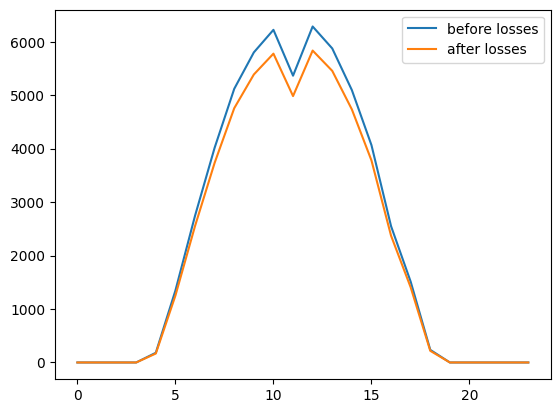

In [16]:
import matplotlib.pyplot as plt

plt.plot(mc.results.ac.values[24*174:24*175], label='before losses')
plt.plot(p_ac_net.values[24*174:24*175], label='after losses')

plt.legend()

In [17]:
pvlib.albedo.SURFACE_ALBEDOS

{'urban': 0.18,
 'grass': 0.2,
 'fresh grass': 0.26,
 'soil': 0.17,
 'sand': 0.4,
 'snow': 0.65,
 'fresh snow': 0.75,
 'asphalt': 0.12,
 'concrete': 0.3,
 'aluminum': 0.85,
 'copper': 0.74,
 'fresh steel': 0.35,
 'dirty steel': 0.08,
 'sea': 0.06}